In [120]:
import pyro
import torch
from pyro.infer.autoguide import AutoNormal
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns

from causal_pyro.dynamical.handlers import (
    PointObservation,
    SimulatorEventLoop,
    simulate,
    ODEDynamics
)
from causal_pyro.dynamical.ops import State, Trajectory

sns.set_style("white")

In [97]:
class SimpleSIRDynamics(ODEDynamics):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        dX.S = -self.beta * X.S * X.I
        dX.I = self.beta * X.S * X.I - self.gamma * X.I  # noqa
        dX.R = self.gamma * X.I

    def observation(self, X: State[torch.Tensor]):
        test_kit_sales = pyro.sample("test_kit_sales", dist.Normal(torch.log10(X.S + 1), 1))
        I_obs = pyro.sample("I_obs", dist.Poisson(X.I)) # noisy number of infected actually observed
        R_obs = pyro.sample("R_obs", dist.Poisson(X.R)) # noisy number of recovered actually observed
        return {"test_kit_sales": test_kit_sales, "I_obs": I_obs, "R_obs": R_obs}

# Generate synthetic data from SIR model

In [132]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = State(S=torch.tensor(99.), I=torch.tensor(1.), R=torch.tensor(0.))

# We measure the population for the next 3 years
time_period = torch.linspace(0, 3, steps=21)

# We would like to estimate the beta and gamma parameters defining the SIR model 
def model():
    beta = pyro.sample("beta", dist.Uniform(0, .25))
    gamma = pyro.sample("gamma", dist.Uniform(0, 1))
    sir = SimpleSIRDynamics(beta, gamma)
    return sir

# We now simulate from the SIR model
sir = model()
sir_traj = simulate(sir, init_state, time_period)

### Plot the simulated trajectories from SIR model

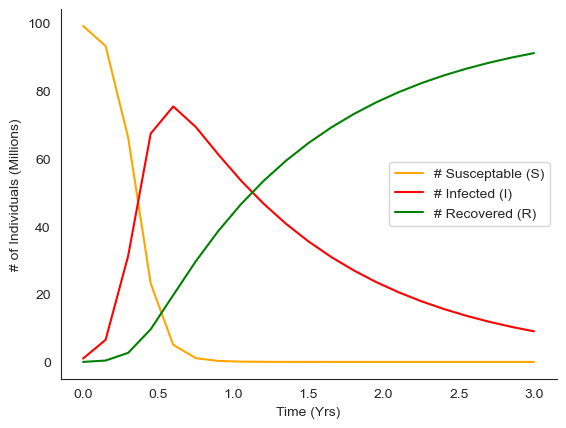

In [133]:
sns.lineplot(x=time_period, y=sir_traj.S, label="# Susceptable (S)", color='orange')
sns.lineplot(x=time_period, y=sir_traj.I, label="# Infected (I)", color='red')
sns.lineplot(x=time_period, y=sir_traj.R, label="# Recovered (R)", color='green')
sns.despine()
plt.xlabel("Time (Yrs)")
plt.ylabel("# of Individuals (Millions)")
plt.legend()

### Sample observed data from the model
 

In [134]:
obs_time_period = torch.arange(0, 3.01, 1/52) # collect data every week
N_obs = obs_time_period.shape[0]
sir_obs_traj = simulate(sir, init_state, obs_time_period)
data = dict()
for time_ix in range(N_obs):
    data[time_ix] = sir.observation(sir_obs_traj[time_ix])

In [135]:
test_kit_sales = torch.stack([data[time_ix]["test_kit_sales"] for time_ix in range(N_obs)])
I_obs = torch.stack([data[time_ix]["I_obs"] for time_ix in range(N_obs)])
R_obs = torch.stack([data[time_ix]["R_obs"] for time_ix in range(N_obs)])

Text(0, 0.5, '# of Recovered (Millions)')

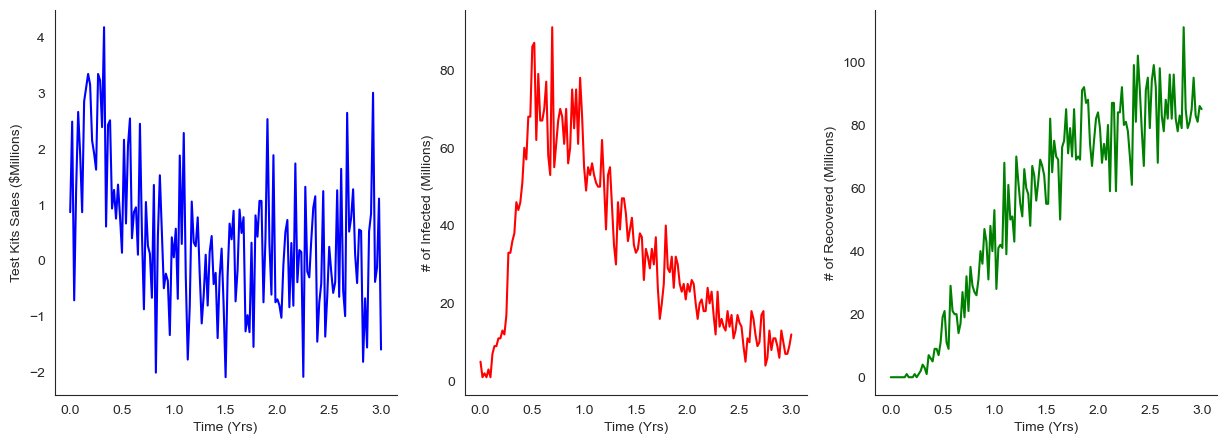

In [141]:
# Plot observed data
fix, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot test kit sales
sns.lineplot(x=obs_time_period, y=test_kit_sales, color='blue', ax=ax[0])
sns.despine()
ax[0].set_xlabel("Time (Yrs)")
ax[0].set_ylabel("Test Kits Sales ($Millions)")

# Plot observed infected
sns.lineplot(x=obs_time_period, y=I_obs, color='red', ax=ax[1])
sns.despine()
ax[1].set_xlabel("Time (Yrs)")
ax[1].set_ylabel("# of Infected (Millions)")

# Plot observed recovered
sns.lineplot(x=obs_time_period, y=R_obs, color='green', ax=ax[2])
sns.despine()
ax[2].set_xlabel("Time (Yrs)")
ax[2].set_ylabel("# of Recovered (Millions)")

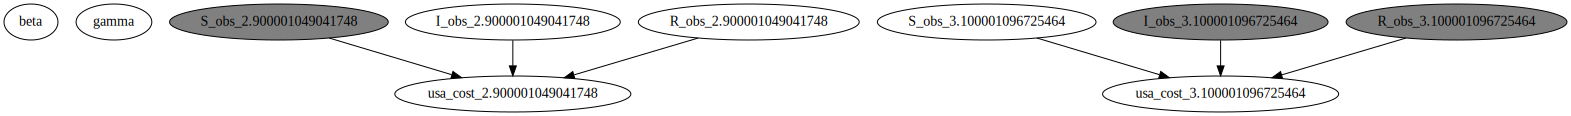

In [67]:
pyro.render_model(model)

In [38]:
# Generate different states for a number of different countries
# Each country conditional on covariates, has same dynamics

# Some countries enact different policies at different times
# pool all information together to estimate dynamics

# References
1. https://www.generable.com/post/fitting-a-basic-sir-model-in-stan